# Pretty Payouts

A notebook used to illustrate the payouts of various derivatives including: <br>
Calls, Puts, & Perpetuals <br>
Can be used to explore multi-leg strategies <br>

Table of Contents:

    0) Imports
    1) Doses & Mimosas
        a) Derivative Classes
        b) Funding Notes
        c) Functions
          i) Black Scholes
          ii) Plotter
    2) Examples

## ToDo:
    1) Add Other funding calculations (simulations?)
    2) Implement sell leverage/liquidations

## 0) Imports

In [ ]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1) Doses & Mimosas

In [155]:
from typing import Type
#@title a) Derivative Classes

class Call():
  '''Vanilla Call Option'''
  '''#ToDo: implement Exotic knockins/knockouts'''
  def __init__(self, strike:float, price:float, n:int=1):
    self.strike = strike
    self.price = price
    self.n = n

  def payout(self, x:np.array):
    y = x-self.strike-self.price
    y = np.where(y < -self.price, -self.price, y)
    return y * self.n


class Put():
  '''Vanilla Put Option'''
  '''#ToDo: implement Exotic knockins/knockouts'''
  def __init__(self, strike:float, price:float, n:int=1):
    self.strike = strike
    self.price = price
    self.n = n

  def payout(self, x:np.array):
    y = self.strike-x-self.price
    y = np.where(y < -self.price, -self.price, y)
    return y * self.n

class Perp():
  '''Power Perpetual'''
  
  def __init__(self, strike:float, power:float, 
               funding_rate:float=0.0, duration:int=0, 
               n:int=1):
    self.strike = strike
    self.power = power
    self.funding_rate = funding_rate
    self.duration = duration
    self.n = n


  def payout(self, x:np.array):
    y = ((((x-self.strike)/self.strike)+1) ** self.power) * self.strike - self.strike

    #Naive Funding Estimation
    y -= self.funding_rate * self.duration

    return y * self.n


### b) Notes

#### Friktion Funding Rate

https://medium.com/friktion-research/power-perpetuals-eli5-part-1-4fd3eee56310

The funding rate is typically the difference between the mark and the index. The funding period affects over what period of time this funding gets paid. In the above example, if SOL-PERP = 105 and SOL = 100, then the 5 in funding is paid out over a period time that equals the funding period.
In typical cases, the 5 would be paid out over 24h with each funding payment happening every hour with the payment = 1/24 * 5.

#### Opyn / Squeeth

https://squeeth.opyn.co/

Continuous in-kind = funding is paid everytime the contract is touched.
 Funding is paid out of your position.

Current Implied Funding = Expected daily funding based on current price, calculated using current mark-index

Historical Daily Funding = Based on last 24 hours, calculated using a 24 hour TWAP of mark-index

#### 01

https://docs.01.xyz/trading/power-perpetuals/powers-funding

Funding is collected hourly based on the ratio between longs and shorts, with a daily funding period. It is calculated using a difference between an hourly TWAP of mark price divided by a normalization factor n and an hourly TWAP of the index price divided by n raised to the power P of the market, over 24 hours.

1h funding = [1h twap mark - (1h twap index^p / n)] / 24

where:
- Index price is the price of the underlying asset
- p is the power of the market
- n is a normalization factor that is a multiple of 10, and used to make numbers more readable
- (twap mark / twap index) is clamped between 0.95 and 1.05

MODEL OPPORTUNITY: <br>
funding Rate VS. % change VS. volatility

In [136]:
# Funding Example
# 2 up moves
hfunding = 5/24
x0 = 99
x1 = 100 - hfunding
x2a = 105 - hfunding*2
x2b = x1*1.05 - hfunding
x2c = 105 + (1 - (1+hfunding)**2)
print(x2a, x2b, x2c)

104.58333333333333 104.57291666666669 104.53993055555556


In [141]:
# 1 down 1 up
hfunding = 5/24
x0 = 99
x1 = 87.5 - hfunding
x2a = 105 - hfunding*2
x2b = x1*1.2 - hfunding
x2c = 105 + (1 - (1+hfunding)**2)
print(x2a, x2b, x2c)

104.58333333333333 104.54166666666667 104.53993055555556


In [140]:
# 2 down moves
hfunding = 5/24
x0 = 99
x1 = 95 - hfunding
x2a = 85.5 - hfunding*2
x2b = x1*.9- hfunding
x2c = 85.5 + (1 - (1+hfunding)**2)
print(x2a, x2b, x2c)

85.08333333333333 85.10416666666667 85.03993055555556


In [142]:
# 1 up 1 down
hfunding = 5/24
x0 = 99
x1 = 100 - hfunding
x2a = 85.5 - hfunding*2
x2b = x1*.855 - hfunding
x2c = 85.5 + (1 - (1+hfunding)**2)
print(x2a, x2b, x2c)

85.08333333333333 85.11354166666668 85.03993055555556


### c) Functions

In [ ]:
#@title i) black_scholes()
def black_scholes(t=40, r=4.00, v=32.00, K=60, St=62, type='c'):
    """
    Parameters:
    K : Excercise Price
    St: Current Stock Price
    v : Volatility in percentage
    r : Risk free rate in percentage
    t : Time to expiration in days
    type: Type of option 'c' for call 'p' for put
    default: 'c'
    """
    # if type = 'c' or 'C' call option else put option
    try:
        type=type.lower()
        if(type=='c'):
            option_type='call'
        else:
            option_type='put'
    except:
        option_type='put'

    #Check time 
    try:
        #convert time in days to years
        t=t/365
    except:
        raise TypeError("Enter numerical value for time")

    #Check risk free rate 
    try:
        #convert percentage to decimal
        r=r/100
    except:
        raise TypeError("Enter numerical value for risk free rate")
    
    #Check volatility
    try:
        #convert percentage to decimal
        v=v/100
    except:
        raise TypeError("Enter numerical value for volatility")  

    #Check Stock Price
    try:
        St=St+0
    except:
        raise TypeError("Enter numerical value for stock price")
    
    #Check Exercise Price
    try:
        K=K+0
    except:
        raise TypeError("Enter numerical value for Exercise price")    
    
    n1=np.log(St/K)
    n2=(r+(np.power(v,2)/2))*t
    d=v*(np.sqrt(t))

    d1=(n1+n2)/d
    d2=d1-(v*np.sqrt(t))

    if type=='c':
        N_d1=norm.cdf(d1)
        N_d2=norm.cdf(d2)
    else:
        N_d1=norm.cdf(-d1)
        N_d2=norm.cdf(-d2)

    A=(St*N_d1)
    B=(K*N_d2*(np.exp(-r*t)))

    if type=='c':
        val=A-B
        val_int=max(0,St-K)
    else:
        val=B-A
        val_int=max(0,K-St)
    val_time=val-val_int

    # Option values in dictionary
    value={'option value':val, 
           'intrinsic value':val_int, 
           'time value':val_time}

    #CALCULATE OPTION GREEKS
    if type=='c':
        delta=N_d1
        theta=(-((St*v*np.exp(-np.power(d1,2)/2))/(np.sqrt(8*np.pi*t)))-(N_d2*r*K*np.exp(-r*t)))/365
        rho=t*K*N_d2*np.exp(-r*t)/100
    else:
        delta=-N_d1
        theta=(-((St*v*np.exp(-np.power(d1,2)/2))/(np.sqrt(8*np.pi*t)))+(N_d2*r*K*np.exp(-r*t)))/365
        rho=-t*K*N_d2*np.exp(-r*t)/100

    gamma=(np.exp(-np.power(d1,2)/2))/(St*v*np.sqrt(2*np.pi*t))
    vega=(St*np.sqrt(t)*np.exp(-np.power(d1,2)/2))/(np.sqrt(2*np.pi)*100)
    
    #Option greeks in Dictionary
    greeks={'delta':delta, 
            'gamma':gamma, 
            'theta':theta, 
            'vega':vega, 
            'rho':rho}

    return {'value':value, 'greeks':greeks}

In [198]:
#@title ii) pretty_plotter()

def pretty_plotter(spot, legs, x_range=20, 
                   show_legs=True, save=False, file='fig.png', glow=False,
                   title="Derivatives Plotter"
                   ):


    spot_range = round(spot * (x_range/100))
    # x=spot*np.arange(100-spot_range,101+spot_range,0.01)/100
    # x = np.array(x)
    x = np.array(range(int(spot - spot_range), int(spot + spot_range), 1))

    y0=np.zeros_like(x)
    
    y_list=[]
    

    for leg in legs:
      y_list.append(leg.payout(x))


    def plotter(title):
        fig, ax = plt.subplots(figsize=(10,6))

        
        plt.style.use("seaborn-dark")
        for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
            plt.rcParams[param] = '#212946'  # bluish dark grey
        for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
            plt.rcParams[param] = '0.9'  # very light grey
        ax.grid(color='#2A3459')  # bluish dark grey, but slightly lighter than background

        y=0
                
        colors = {'Call':'lime', 'Put':'red'}
        for i,leg in enumerate(legs):
          if show_legs:
            label = f'{leg.n} {leg.__class__.__name__} ST: {leg.strike}'
            sns.lineplot(x=x, y=y_list[i], label=label, alpha=0.5, 
                         color=colors.get(leg.__class__.__name__, 'yellow'),
                         linestyle=':',)
          y+=np.array(y_list[i])


        sns.lineplot(x=x, y=y, label='combined', alpha=1, color='cyan')
        plt.axhline(color='k', linestyle='--')
        plt.axvline(x=spot, color='fuchsia', linestyle='--', label='spot price')
        plt.legend()
        plt.legend(loc='best')
        title=title
        plt.title(title)
        plt.fill_between(x, y, 0, alpha=0.1, where=y>y0, facecolor='cyan', interpolate=True)
        plt.fill_between(x, y, 0, alpha=0.1, where=y<y0, facecolor='fuchsia', interpolate=True)
        plt.tight_layout()


        if glow:
          n_lines = 10
          diff_linewidth = 1.05
          alpha_value = 0.03
          for w in range(n_lines):
              sns.lineplot(x=x, y=y,
                          alpha=alpha_value, 
                          color='cyan', 
                          linewidth=2+(diff_linewidth*w),
                          legend=False,)


        if save==True:
            plt.savefig(file)
        plt.show()

    plotter(title)    

## 2) Examples

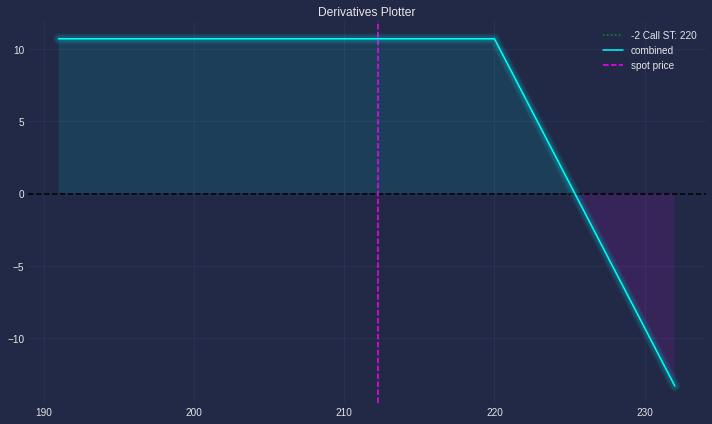

In [199]:
#@title Short 2 calls
legs =[
       Call(strike=220, price=5.35, n=-2),
      ]

pretty_plotter(spot=212.26, legs=legs, x_range=10, show_legs=True, glow=True)

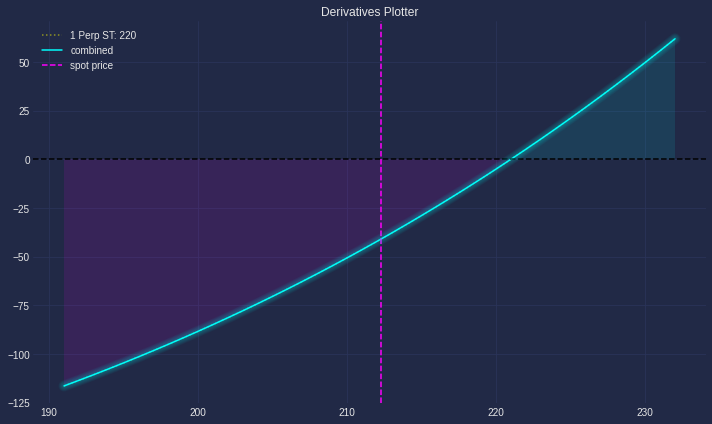

In [200]:
#@title Long 1 Power Perp
legs =[
       Perp(strike=220, power=5, funding_rate = 5/24, duration =24, n=1)
      ]

pretty_plotter(spot=212.26, legs=legs, x_range=10, show_legs=True, glow=True)

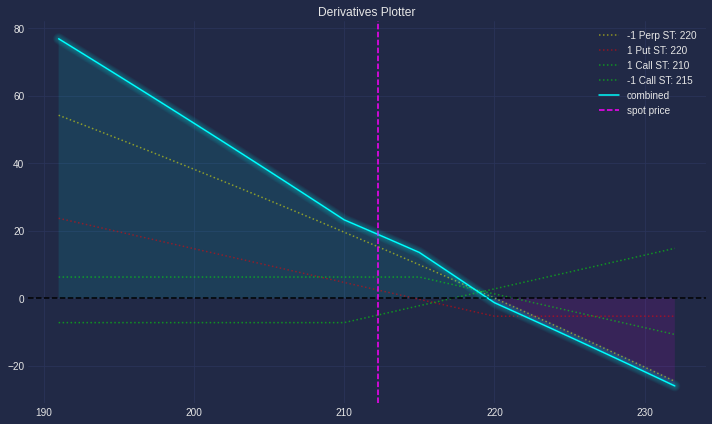

In [201]:
#@title Multi Leg Example
legs =[
       Perp(strike=220, power=2, n=-1),
       Put(strike=220, price=5.35, n=1),
       Call(strike=210, price=7.25, n=1),
       Call(strike=215, price=6.25, n=-1)
      ]


pretty_plotter(spot=212.26, legs=legs, x_range=10, show_legs=True, glow=True)

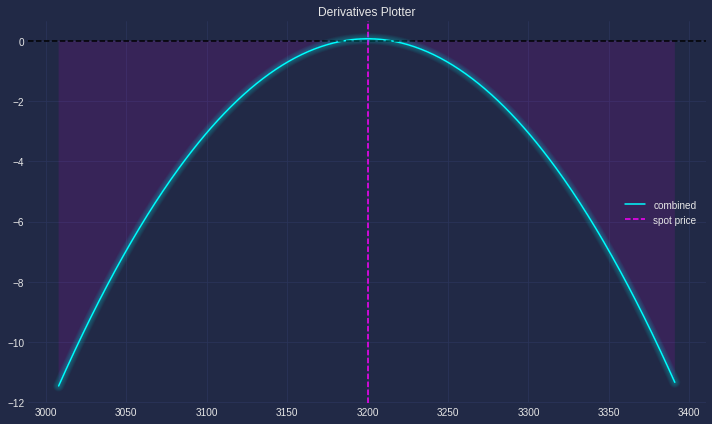

In [206]:
#@title Crab Strategy from [Opyn](https://opyn.gitbook.io/squeeth/resources/squeeth-strategies-faq)

'''
Short Squeeth + Long Eth
Based on current funding, 
crab strategy would be unprofitable if ETH moves more than
approximately 5.21% in either direction each day.
The implied funding rate at which you deposit at impacts
your profitability. Depositing at a high funding rate
increases likelihood of profitability.
'''

legs =[
       Perp(strike=3200, power=2, funding_rate=.0027, duration=24, n=-1),
       Perp(strike=3200, power=1, funding_rate=0, n=2),
      ]


pretty_plotter(spot=3200, legs=legs, x_range=6, show_legs=False, glow=True)